In [0]:
import sys

import numpy as np
from scipy.stats import bernoulli
from math import log

import random
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Practical Session on Stochastic Linear Bandits :

The architecture of code below provides the environment to run a standard linear bandit experiment. 

## LinUCB : Implementing optimism in $R^d$

* Implement LinUCB as studied in class. In your opinion, what is (are) the bottleneck(s) of this algorithm ? 
* One key step is to invert the covariance matrix in order to compute the elliptical norm of each available action. At round $t+1$ the new covariance matrix is very similar to the previous one... Can you think of a way to optimize this step by simply updating the old one ? 
Hint : You can search for a way to compute the inverse of the sum of an invertible matrix A and the outer product, $ uv^\top$, of vectors u and v.
* It is common practice to tweak LinUCB by multiplying the confidence bonus by some hyperparameter $ 0<\alpha <1 $. 
What would be the effect of doing so ? Do you think it is a good idea ? What are the risks ?

## LinTS : Taking the Bayesian way

Thompson Sampling is a popular bayesian alternative to the standard optimistic bandit algorithms (see Chapter 36 of Bandit Algorithms). The key idea is to rely on Bayesian samples to get a proxy for the hidden parameter $\theta$ of the problem instead of building high-probability confidence regions. 

* Let us place a Gaussian prior with mean $\mathbf{0}$ and covariance $\sigma_0 I$ on $\theta$. Given actions $A_1,\ldots,A_t$ and rewards $Y_1,\ldots,Y_t$, Can you compute the expression of the posterior at the beginning of round $t+1$ ? 
* Implement LinTS (Linear Thompson Sampling)

# Plot Function

In [0]:
## Plot function : 
#-*-coding: utf-8 -*-

current_palette = sns.color_palette()
sns.set_style("ticks")


styles = ['o', '^', 's', 'D', '*']
colors = current_palette[0:4]+current_palette[5:6]
color_lb = current_palette[4]

algos = {'LinUCB': 'LinUCB',
         'LinUCB_alpha': 'LinUCB_alpha',
         'Unif': 'Unif',
         'Optimized_linUCB':'Optimized_linUCB'}

def plot_regret(data, tsav, filename, log=False, taum=False,
                freq=50, qtl=False):
    fig = plt.figure(figsize=(7, 6))
    Nsub = len(tsav)
    T = len(data[0][1]) # length of regret
    N_curves = len(data)
    if log == True:
        plt.xscale('log')
        markevery = 1. / 12
        freq = 1
    i = 0
    
    for key, regret, avgRegret, qRegret, QRegret in data:
        T = len(regret)
        if qtl:
            label = algos[key] # r"\textbf{%s}" % 
            plt.plot(tsav, avgRegret, marker=styles[i], markevery=4,
                     ms=10.0, label=label, color=colors[i])
            plt.fill_between(tsav, qRegret, QRegret, alpha=0.15, 
                             linewidth=1.5, color=colors[i])
        else:
            label = algos[key] #r"\textbf{%s}" % algos[key]
            plt.plot(np.arange(len(regret))[0::freq], regret[0::freq],
                     marker=styles[i], ms=10.0,
                     label=label, color=colors[i])
        i += 1

    plt.legend(loc=2)
    plt.xlabel('Round t', fontsize=20)
    plt.ylabel('Regret R(T)', fontsize=18)
        
    plt.savefig('%s.pdf' % (filename), bbox_inches='tight')
    plt.show()
    plt.close(fig)
    return
  
 


# Action generators 

In [0]:
def randomActionsGenerator(K,d):
  """
  K: int -- number of action vectors to be generated
  d : int -- dimension of the action space
  returns : an array of K vectors uniformly sampled on the unit sphere in R^d
  """

  vecs = np.random.multivariate_normal(np.zeros(d), np.eye(d), size =K)
  norms = np.linalg.norm(vecs,axis=1)
  return vecs / norms[:,np.newaxis]

In [0]:
a = randomActionsGenerator(100,2)


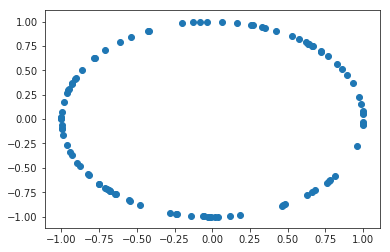

In [13]:
plt.scatter(a[:,0],a[:,1])

# Environment Class

In [0]:
class Environment:
  """
    Parameters:
    -----------
    K:  int
        Number of arms generated at each round

    d: int
        Dimension of the problem

    theta: d-dimensional vector
        Key hidden parameter of the problem


    """

  def __init__(self, d, K, theta):
    self.theta = theta
    self.d = d
    self.K = K
    

  

  def play(self, chosen_arm):
    """Play the arm with index choice and returns the corresponding reward:

        expected_reward + gaussian_noise
        """

    expected_reward = np.dot(chosen_arm, self.theta)
    reward = np.random.normal(expected_reward)

    return chosen_arm, expected_reward, reward

  def getBestArm(self, arms):
    """Return the index of the best arm and the corresponding expected payoff"""
    payoffs = np.zeros(self.K)
    for i in range(self.K):
      payoffs[i] = np.dot(arms[i,:], self.theta)

    bestArm = np.argmax(payoffs)
    return bestArm, payoffs[bestArm]

#Simulator

In [0]:
class Simulator():
  """
    Simulator of stochastic delayed games.

    Params:
    -------

    policies: list
        List of policies to test.

    K: int
        Number of arms to be generated at each round

    d: int
        Dimension of the problem

    """

  def __init__(self, environment, policies, K, d):
    self.env = environment
    self.policies = policies
    self.d = d
    self.K = K

  def run(self, T, N, q, tsav):
    """Runs an experiment with parameters T and N.

        It returns a dictionary whose keys are policies and whose values
        are the regret obtained by these policies over the experiments and
        averaged over N runs.qRegret and QRegret are the first and third quartiles.

        Parameters
        ----------
        T: int
            Length of the sequential allocations.

        N: int
            Number of Monte Carlo repetitions.

        q: int
            Quantile parameter (e.g. 25 -> quartiles)

        tsav: numpy array (ndim = 1)
            Points to save on each trajectory.
        """
    #Nsub = np.size(tsav)

    regret, cumRegret, N_plays = dict(), dict(), dict()
    Nsub = np.size(tsav)  # Number of points saved for each trajectory
    avgRegret, qRegret, QRegret = dict(), dict(), dict()

    for policy in self.policies:
      name = policy.id()
      cumRegret[name] = np.zeros((N, Nsub))
      regret[name] = np.zeros(T)

    for nExp in range(N):

      if N < 10 or nExp % (N / 5) == 0:
        print "experiments executed:", nExp
        sys.stdout.flush()

      for policy in self.policies:

        name = policy.id()
        # Reinitialize the policy
        policy.init()
        optimalRewards = np.zeros(T)
        rewards = np.zeros(T)

        # We follow the policy
        #print "ready for experiment %d" % (nExp)
        for t in range(T):

          # get arms, play one of them (policy), get reward:
          availableArms = randomActionsGenerator(self.K,self.d)  
          A_t = policy.selectArm(availableArms, self.K)
          chosen_arm, expected_reward, reward = self.env.play(availableArms[A_t,:])

          #update the policy:
          policy.updateState(chosen_arm,reward)

          #compute instant pseudo regret
          instantBestArm, instantBestReward = self.env.getBestArm(availableArms)
          optimalRewards[t] += instantBestReward
          rewards[t] += expected_reward
        

        regret[name] += (optimalRewards - rewards) 
        cumRegret[name][nExp] += np.cumsum(optimalRewards - rewards)[tsav]


    print("build data out of the experiments")
    for policy in self.policies:
      name = policy.id()
      regret[name] = np.cumsum(regret[name]) / N

      cumReg = cumRegret[name]
      avgRegret[name] = np.mean(cumReg, 0)
      qRegret[name] = np.percentile(cumReg, q, 0)
      QRegret[name] = np.percentile(cumReg, 100 - q, 0)

    print("data built")
    return regret, avgRegret, qRegret, QRegret

# Policies

In [0]:


class Policy(object):

  def __init__(self, K, T):
    """
        Constructor.
        """
    raise NotImplementedError("Method `__init__` is not implemented.")

  def selectArm(self):
    """
        This functions selects L arms among the K ones depending on statistics
        over the past observations.
        """
    raise NotImplementedError("Method `selectArms` is not implemented.")

  def updateState(self):
    """
        This function updates the statistics given the new observations.
        """
    raise NotImplementedError("Method `updateState` is not implemented.")

  def init(self):
    """
        This function updates the statistics given the new observations.
        """
    raise NotImplementedError("Method `updateState` is not implemented.") 

  #@staticmethod
  def id(self):
    raise NotImplementedError("Static method `id` is not implemented.")


####**below we implemented the linUCB algorithm learned in class**

In [0]:
## Policies :

class Uniform(Policy):
  def __init__(self, T,d):
    pass

  def selectArm(self, arms, K):
    return np.random.choice(K)

  def updateState(self, chosen_arm, reward):
    pass

  def init(self):
    pass

  #@staticmethod
  def id(self):
    return 'Unif'

from numpy.linalg import pinv

#Implementation of LinUCB as studied in class
class LinUCB(Policy):

  def __init__(self, T, d, alpha,delta,lamda,K,S):
    self.T = T
    self.d = d
    self.alpha=alpha
    self.delta = delta
    self.lamda=lamda
    self.K = K
    self.S = S
    #dropping the loglog(t) term for now

  def init(self):
    self.t = 0
    self.V = self.lamda*np.eye(self.d)
    self.b = np.zeros(self.d)
    self.Beta = self.alpha*(np.sqrt(self.lamda)*self.S + np.sqrt(2*np.log(1/self.delta) + self.d*np.log((self.lamda*self.d+self.t)/(self.lamda*self.d)))) 
    

  def selectArm(self, arms, K):
    """
        This function implements LinUCB
        Input:
        -------
        arms : list of arms (d-dimensional vectors)

        Output:
        -------
        chosen_arm : index of the pulled arm
        """
    inV = pinv(self.V) #inverted V
    teta = np.matmul(inV,np.transpose(self.b))
    pay_off_t = [np.matmul(arms[i],teta) + np.sqrt(self.Beta*(np.matmul(np.transpose(arms[i]),np.matmul(inV,arms[i])))) for i in range(self.K)]
    return np.argmax(pay_off_t)

    

  def updateState(self, chosen_arm, reward):

    self.t+=1
    self.V += np.outer(np.transpose(chosen_arm),chosen_arm)
    self.b += chosen_arm*reward
    self.Beta = self.alpha*(np.sqrt(self.lamda)*self.S + np.sqrt(2*np.log(1/self.delta) + self.d*np.log((self.lamda*self.d+self.t)/(self.lamda*self.d))))
    pass


  def id(self):
    return "LinUCB"

  

##**bottlenecks answer here**

Not only is this algorithm computationnaly expensive, it provides hurdles via the choosing of the confidence interval which is vital 

# main

In [25]:
import time
import numpy as np
import pickle

d = 15  # dimension
K = 30  # number of arms

# parametor vector \theta, normalized :
theta = np.random.randint(2, size=d)
theta = theta / np.linalg.norm(theta)


T = 1000  # Finite Horizon
N = 10  # Monte Carlo simulations

delta = 0.1

# save subsampled points for Figures
Nsub = 100
tsav = range(2, T, Nsub)

#choice of quantile display
q = 10



alpha= 1
lamda=0.5
S=1

def main(N):

  # Create an object of K arms with delayed feedback with mean delay tau
  env = Environment(d, K, theta)
  # Policies to evaluate
  policies = [LinUCB(T, d, alpha,delta,lamda,K,S), 
              Uniform(T,d)]

  simulator = Simulator(env, policies, K, d)

  regret, avgRegret, qRegret, QRegret= simulator.run(T, N, q, tsav)

  data = [[
      policy, regret[policy], avgRegret[policy], qRegret[policy],
      QRegret[policy]
  ] for policy in avgRegret]

  return data


data = main(N)
  
  #data 
#   with open('linucb_test' + str(d) + '_dim-' + str(K) + '_K' + '.pkl',
#             'wb') as foutput:
#     pickle.dump(data, foutput, protocol=2)


  
  
 

experiments executed: 0
experiments executed: 2
experiments executed: 4
experiments executed: 6
experiments executed: 8
build data out of the experiments
data built


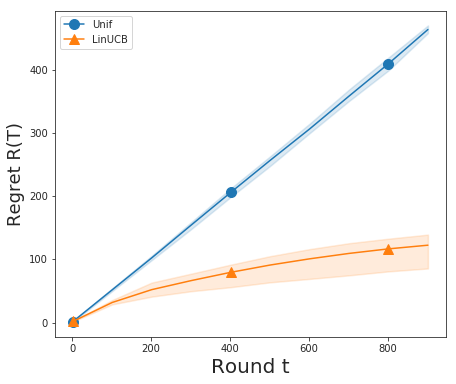

In [26]:

freq = 10
plot_regret(
    data,
    tsav,
    'linucb_test' + str(d) + '_dim-' + str(K) + '_K',
    log=False,
    freq=freq,
    qtl=True)

##**Modifing the inversion of the covariance matrix**

One key step is to invert the covariance matrix in order to compute the elliptical norm of each available action. At round $t+1$ the new covariance matrix is very similar to the previous one... Can you think of a way to optimize this step by simply updating the old one ? 
Hint : You can search for a way to compute the inverse of the sum of an invertible matrix A and the outer product, $ uv^\top$, of vectors u and v.

we can optimize this porcess by using  the Sherman–Morrison formula that states that given invertible matrix A and the outer product, uv⊤, of vectors u and v:

<math>\begin{align}
   (A + uv^\textsf{T})^{-1} =  A^{-1} -{A^{-1}uv^\textsf{T}A^{-1}\over 1 + v^\textsf{T}A^{-1}u}  \\[6pt] \\
\end{align}</math>


let's apply this to our new algorithm 

In [0]:
"this function does the optimized version of the inversion of the covariance matrix "
def optimized_inversion(A,u,v):
  a=np.outer(u,np.transpose(v))
  res=A-(np.matmul(A, np.matmul(a, A))/(np.matmul(np.transpose(v),np.matmul(A,u))+1)) #cf M formula above 
  return res

now let's modify our LinUCB into Optimized_linUCB

In [0]:
class Optimized_linUCB(Policy):

  def __init__(self, T, d, alpha,delta,lamda,K,S):
    self.T = T
    self.d = d
    self.alpha=alpha
    self.delta = delta
    self.lamda=lamda
    self.K = K
    self.S = S
    #dropping the loglog(t) term for now

  def init(self):
    self.t = 0
    self.V = self.lamda*np.eye(self.d)
    self.inV = (1/self.lamda)*np.eye(self.d) #inverted V here initialised accordingly to wha we re going to apply 
    self.b = np.zeros(self.d)
    self.Beta = self.alpha*(np.sqrt(self.lamda)*self.S + np.sqrt(2*np.log(1/self.delta) + self.d*np.log((self.lamda*self.d+self.t)/(self.lamda*self.d)))) 
    
    

  def selectArm(self, arms, K):
    """
        This function implements optimized_linUCB
        Input:
        -------
        arms : list of arms (d-dimensional vectors)

        Output:
        -------
        chosen_arm : index of the pulled arm
        """
    

    teta = np.matmul(self.inV,np.transpose(self.b))
    pay_off_t = [np.matmul(arms[i],teta) + np.sqrt(self.Beta*(np.matmul(np.transpose(arms[i]),np.matmul(self.inV,arms[i])))) for i in range(self.K)]
    return np.argmax(pay_off_t)

    

  def updateState(self,chosen_arm,reward):
    self.t+=1
    self.V += np.outer(np.transpose(chosen_arm),chosen_arm)
    self.inV = optimized_inversion(self.inV,chosen_arm,chosen_arm) #here we give it the previous inverted one since we are computing reccursively
    self.b += chosen_arm*reward
    self.Beta = self.alpha*(np.sqrt(self.lamda)*self.S + np.sqrt(2*np.log(1/self.delta) + self.d*np.log((self.lamda*self.d + self.t)/(self.lamda*self.d))))
    pass


  def id(self):
    return "Optimized_linUCB"


let's rerun using **MAIN**

experiments executed: 0
experiments executed: 2
experiments executed: 4
experiments executed: 6
experiments executed: 8
build data out of the experiments
data built


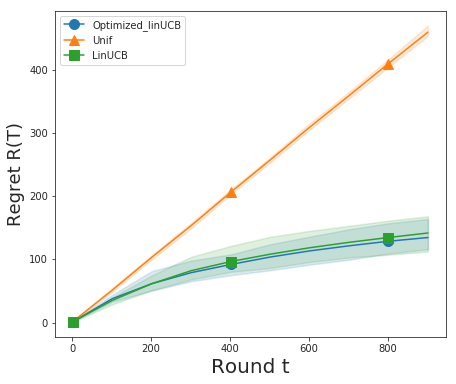

In [29]:

def main_bis(N):
  # Create an object of K arms with delayed feedback with mean delay tau
  env = Environment(d, K, theta)
  # Policies to evaluate
  policies = [LinUCB(T, d, alpha,delta,lamda,K,S), 
              Uniform(T,d),Optimized_linUCB(T, d, alpha,delta,lamda,K,S)]

  simulator = Simulator(env, policies, K, d)

  regret, avgRegret, qRegret, QRegret= simulator.run(T, N, q, tsav)

  data = [[
      policy, regret[policy], avgRegret[policy], qRegret[policy],
      QRegret[policy]
  ] for policy in avgRegret]

  return data


data = main_bis(N)
  
  #data 
#   with open('linucb_test' + str(d) + '_dim-' + str(K) + '_K' + '.pkl',
#             'wb') as foutput:
#     pickle.dump(data, foutput, protocol=2)


freq = 10
plot_regret(
    data,
    tsav,
    'linucb_test' + str(d) + '_dim-' + str(K) + '_K',
    log=False,
    freq=freq,
    qtl=True) 

###**tel's compare the speed of our two LinUCB** 

In [30]:
def main_linUCB(N):
  # Create an object of K arms with delayed feedback with mean delay tau
  env = Environment(d, K, theta)
  # Policies to evaluate
  policies = [LinUCB(T, d, alpha,delta,lamda,K,S)]

  simulator = Simulator(env, policies, K, d)

  regret, avgRegret, qRegret, QRegret= simulator.run(T, N, q, tsav)

  data = [[
      policy, regret[policy], avgRegret[policy], qRegret[policy],
      QRegret[policy]
  ] for policy in avgRegret]

  return data

def main_optimized_linUCB(N):
  # Create an object of K arms with delayed feedback with mean delay tau
  env = Environment(d, K, theta)
  # Policies to evaluate
  policies = [Optimized_linUCB(T, d, alpha,delta,lamda,K,S)]

  simulator = Simulator(env, policies, K, d)

  regret, avgRegret, qRegret, QRegret= simulator.run(T, N, q, tsav)

  data = [[
      policy, regret[policy], avgRegret[policy], qRegret[policy],
      QRegret[policy]
  ] for policy in avgRegret]

  return data


start = time.time()
linucb = main_linUCB(N)
end = time.time()   
print('time for linUCB : '+str(end-start))

start = time.time()
optim_linucb = main_optimized_linUCB(N)
end = time.time()   
print('time for Optimized linUCB : '+str(end-start))


experiments executed: 0
experiments executed: 2
experiments executed: 4
experiments executed: 6
experiments executed: 8
build data out of the experiments
data built
time for linUCB : 7.59765195847
experiments executed: 0
experiments executed: 2
experiments executed: 4
experiments executed: 6
experiments executed: 8
build data out of the experiments
data built
time for Optimized linUCB : 5.80634093285


we indeed have a slightly faster algorithm using our inversion method on this small datast we can only imagine the advatages we'd ave for a larger one.

###**differents values of alpha**

In [0]:
class LinUCB_alpha(Policy):

  def __init__(self, T, d, alpha,delta,lamda,K,S):
    self.T = T
    self.d = d
    self.alpha=alpha
    self.delta = delta
    self.lamda=lamda
    self.K = K
    self.S = S
    #dropping the loglog(t) term for now

  def init(self):
    self.t = 0
    self.V = self.lamda*np.eye(self.d)
    self.b = np.zeros(self.d)
    self.Beta = self.alpha*(np.sqrt(self.lamda)*self.S + np.sqrt(2*np.log(1/self.delta) + self.d*np.log((self.lamda*self.d+self.t)/(self.lamda*self.d)))) 
    

  def selectArm(self, arms, K):
    """
        This function implements LinUCB
        Input:
        -------
        arms : list of arms (d-dimensional vectors)

        Output:
        -------
        chosen_arm : index of the pulled arm
        """
    inV = pinv(self.V) #inverted V
    teta = np.matmul(inV,np.transpose(self.b))
    pay_off_t = [np.matmul(arms[i],teta) + np.sqrt(self.Beta*(np.matmul(np.transpose(arms[i]),np.matmul(inV,arms[i])))) for i in range(self.K)]
    return np.argmax(pay_off_t)

    

  def updateState(self, chosen_arm, reward):

    self.t+=1
    self.V += np.outer(np.transpose(chosen_arm),chosen_arm)
    self.b += chosen_arm*reward
    self.Beta = self.alpha*(np.sqrt(self.lamda)*self.S + np.sqrt(2*np.log(1/self.delta) + self.d*np.log((self.lamda*self.d+self.t)/(self.lamda*self.d))))
    pass


  def id(self):
    return "LinUCB_alpha"

  

experiments executed: 0
experiments executed: 2
experiments executed: 4
experiments executed: 6
experiments executed: 8
build data out of the experiments
data built


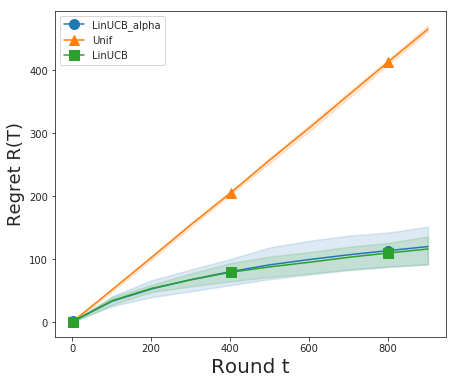

In [32]:


d = 15  # dimension
K = 30  # number of arms

# parametor vector \theta, normalized :
theta = np.random.randint(2, size=d)
theta = theta / np.linalg.norm(theta)


T = 1000  # Finite Horizon
N = 10  # Monte Carlo simulations

delta = 0.1

# save subsampled points for Figures
Nsub = 100
tsav = range(2, T, Nsub)

#choice of quantile display
q = 10



alpha= 0.5
lamda=0.5
S=1

def main(N):

  # Create an object of K arms with delayed feedback with mean delay tau
  env = Environment(d, K, theta)
  # Policies to evaluate
  policies = [LinUCB(T, d, alpha,delta,lamda,K,S), 
              Uniform(T,d),LinUCB_alpha(T, d, alpha,delta,lamda,K,S)]

  simulator = Simulator(env, policies, K, d)

  regret, avgRegret, qRegret, QRegret= simulator.run(T, N, q, tsav)

  data = [[
      policy, regret[policy], avgRegret[policy], qRegret[policy],
      QRegret[policy]
  ] for policy in avgRegret]

  return data


data = main(N)

freq = 10
plot_regret(
    data,
    tsav,
    'linucb_test' + str(d) + '_dim-' + str(K) + '_K',
    log=False,
    freq=freq,
    qtl=True)

experiments executed: 0
experiments executed: 2
experiments executed: 4
experiments executed: 6
experiments executed: 8
build data out of the experiments
data built


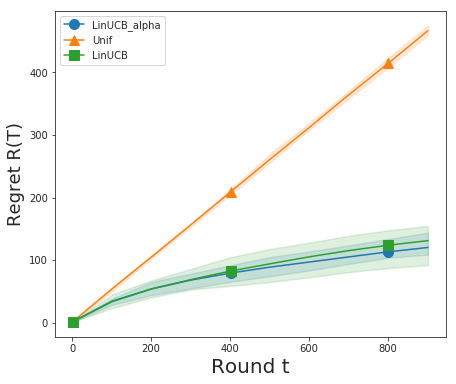

In [33]:


d = 15  # dimension
K = 30  # number of arms

# parametor vector \theta, normalized :
theta = np.random.randint(2, size=d)
theta = theta / np.linalg.norm(theta)


T = 1000  # Finite Horizon
N = 10  # Monte Carlo simulations

delta = 0.1

# save subsampled points for Figures
Nsub = 100
tsav = range(2, T, Nsub)

#choice of quantile display
q = 10



alpha= 0.01
lamda=0.5
S=1

def main(N):

  # Create an object of K arms with delayed feedback with mean delay tau
  env = Environment(d, K, theta)
  # Policies to evaluate
  policies = [LinUCB(T, d, alpha,delta,lamda,K,S), 
              Uniform(T,d),LinUCB_alpha(T, d, alpha,delta,lamda,K,S)]

  simulator = Simulator(env, policies, K, d)

  regret, avgRegret, qRegret, QRegret= simulator.run(T, N, q, tsav)

  data = [[
      policy, regret[policy], avgRegret[policy], qRegret[policy],
      QRegret[policy]
  ] for policy in avgRegret]

  return data


data = main(N)

freq = 10
plot_regret(
    data,
    tsav,
    'linucb_test' + str(d) + '_dim-' + str(K) + '_K',
    log=False,
    freq=freq,
    qtl=True)

multiplying by a small alpha seems to give better result which makes alpha a hyperparameter. The other ones could also be tweeked   